C:\Users\Ice\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


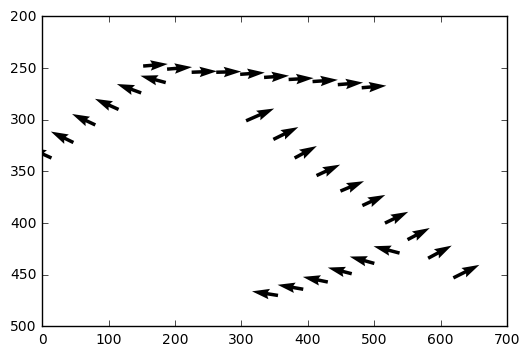

[ 36.5         35.15       -36.83333333 -34.5       ]
[  2.4         17.05         8.16666667  14.25      ]


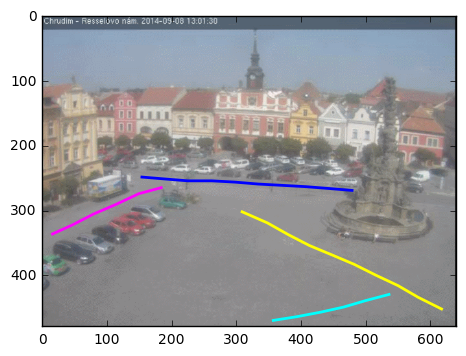

In [187]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
from matplotlib import collections as mc 
import os

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Tunable Variables
days_to_process = 7
pd.options.display.max_rows = 1000

# Loading data
col_names = ['TrackID','FrameNo', 'X', 'Y']
# day1 = pd.read_table("001_20130101.txt",delimiter=" ", header=None, names=col_names)
# day2 = pd.read_table("001_20130102.txt",delimiter=" ", header=None, names=col_names)
# day3 = pd.read_table("001_20130103.txt",delimiter=" ", header=None, names=col_names)
# day4 = pd.read_table("001_20130104.txt",delimiter=" ", header=None, names=col_names)
# day5 = pd.read_table("001_20130105.txt",delimiter=" ", header=None, names=col_names)
# day6 = pd.read_table("001_20130106.txt",delimiter=" ", header=None, names=col_names)
# day7 = pd.read_table("001_20130107.txt",delimiter=" ", header=None, names=col_names)

day1 = pd.read_table("001_20130212.txt",delimiter=" ", header=None, names=col_names)
day2 = pd.read_table("001_20130214.txt",delimiter=" ", header=None, names=col_names)
day3 = pd.read_table("001_20130215.txt",delimiter=" ", header=None, names=col_names)
day4 = pd.read_table("001_20130216.txt",delimiter=" ", header=None, names=col_names)
day5 = pd.read_table("001_20130217.txt",delimiter=" ", header=None, names=col_names)
day6 = pd.read_table("001_20130218.txt",delimiter=" ", header=None, names=col_names)
day7 = pd.read_table("001_20130219.txt",delimiter=" ", header=None, names=col_names)

frames = [day1, day2, day3, day4, day5, day6, day7]
concatDay = pd.concat(frames, ignore_index=True)
# concatDay = concatDay.sort_values(by='TrackID', ascending=True)
# concatDay
# TraClusFileExporter(concatDay)


clusteredTracks = ReadTraclusExport('LOST3output.txt')
# print(clusteredTracks)
average_grad_X, average_grad_Y = calculateVector(clusteredTracks)

cluster = TrajectoryID_Extraction(clusteredTracks)
# print(cluster)
# colors_for_lines = ColorAssignment(cluster)
colors_for_lines = ColorAssignment(clusteredTracks)
# print(colors_for_lines)
# cluster_line = LinesConstruct(cluster)
cluster_line = LinesConstruct(clusteredTracks)
# np.set_printoptions(threshold='nan')
# print(colors_for_lines)

Visualizer(cluster_line, colors_for_lines)

In [185]:
def calculateGradient(dataframeInput):
    tempnp = pd.DataFrame.as_matrix(dataframeInput[['X']])
    tempnp = tempnp.ravel()
    dataframe_gradient_X = np.gradient(tempnp)
    
    tempnp = pd.DataFrame.as_matrix(dataframeInput[['Y']])
    tempnp = tempnp.ravel()
    dataframe_gradient_Y = np.gradient(tempnp)

    return dataframe_gradient_X, dataframe_gradient_Y
    
def calculateVector(dataframeInput):
    #####################Separate clusters for mean calculation################################
    tempNP_splitter = []
    pivot = 0
    pivoted_cluster_id = dataframeInput[['TrackID']].loc[pivot]
    pivoted_cluster_id = pivoted_cluster_id.TrackID
    while pivot < len(dataframeInput):        
        current_cluster_id = dataframeInput[['TrackID']].loc[pivot]
        current_cluster_id = current_cluster_id.TrackID
        if current_cluster_id != pivoted_cluster_id:
            tempNP_splitter += [pivot]
            pivoted_cluster_id = current_cluster_id
        pivot += 1
    
    counter = 0
    current_pivot = 0
    visualize_np_X = np.empty(0)
    visualize_np_Y = np.empty(0)
    average_np_X = np.empty(0)
    average_np_Y = np.empty(0)
    while counter <= len(tempNP_splitter):
        try:
            tempDF_X, tempDF_Y = calculateGradient(dataframeInput[current_pivot:tempNP_splitter[counter]])
        except:
            tempDF_X, tempDF_Y = calculateGradient(dataframeInput[current_pivot:(dataframeInput.iloc[-1].name + 1)])
        try:
            current_pivot = tempNP_splitter[counter]
        except:
            current_pivot = 0
        visualize_np_X = np.append(visualize_np_X, tempDF_X)
        visualize_np_Y = np.append(visualize_np_Y, tempDF_Y)
        tempDF_X = np.mean(tempDF_X)
        tempDF_Y = np.mean(tempDF_Y)
        average_np_X = np.append(average_np_X, tempDF_X)
        average_np_Y = np.append(average_np_Y, tempDF_Y)
        counter += 1

    ###########################################################################################
    
    ################## Average gradient for each cluster##############
    temp_grad_X = pd.DataFrame.mean(dataframeInput[['X']], axis = 0)
    temp_grad_Y = pd.DataFrame.mean(dataframeInput[['Y']], axis = 0)
    ##################################################################
    
    
    ######################## Plotting ###################################
    plt.gca().invert_yaxis()
    plt.quiver(dataframeInput[['X']], dataframeInput[['Y']], visualize_np_X, visualize_np_Y)
    plt.show()
    #####################################################################
    return average_np_X, average_np_Y

In [10]:
# Get the output from TraClus, revamp and prepare data to visualize
# to achieve this, i need to read from text file and reconstruct it back to a dataframe.
def ReadTraclusExport(filename):
    fileOpener = open(filename, 'r')
    lines_ori = fileOpener.readlines()

    ########Choose the rows with X Y coordinates####################################
    #a loop is needed to differentiate the xy and affilitated trajectory's id
    counterLineNumber = 0 
    for lines in lines_ori:
        indexOfTraj = lines.find("trajectoryID: 0")
        if indexOfTraj == 0:
            break
        counterLineNumber += 1

    start = 2
    end = counterLineNumber 
    step = 2
    lines = lines_ori[start:end:step]
    ################################################################################

    ####################Choose the rows with ID and number of points################
    clusterID_array = []
    num_points = []
    start = 1
    end = counterLineNumber
    step = 2
    lines_ID = lines_ori[start:end:step]
    length_lines_ID = len(lines_ID)
    counter_for_linesID = 0
    
    #a global list for accessment
    global end, lines_ori
    
    while counter_for_linesID < length_lines_ID:
        temp_lines_ID = str(lines_ID[counter_for_linesID])
        temp_index = temp_lines_ID.find(" ")
        temp_index3 = temp_lines_ID.find("P")
        temp_index2 = temp_lines_ID.find("  ", 14, len(temp_lines_ID))
        clusterID_array += [temp_lines_ID[temp_index + 1:temp_index3]]
        num_points += [temp_lines_ID[temp_index2 + 2:]]
        counter_for_linesID += 1
    ##################################################################################

    #Strip the string into appropriate form
    element = str(lines)
    elementText = element[0:-1]
    elementText = str.replace(elementText, '\\' , '')
    elementText = str.replace(elementText, "n", '')
    elementText = str.replace(elementText, "   ", " ")
    elementText = str.replace(elementText, ",", "\n")
    elementText = str.replace(elementText, "\n", '')
    elementText = str.replace(elementText, "'", "" )
    elementText = str.replace(elementText, "  "," ")
    elementText = str.replace(elementText, "[", "")

    #put in 2d array form and convert to integer
    numpyString = np.fromstring(elementText, dtype=float, sep= ' ' or '\n')
    numpyInt = numpyString.astype(int)
    number_of_rows = int( len(numpyInt)/2 )
    numpyInt = numpyInt.reshape((number_of_rows,2))

    #convert numpy array to dataframe
    dataframeInt = pd.DataFrame(numpyInt)
    dataframeInt.columns = ['X', 'Y']
    dataframeInt = dataframeInt.convert_objects(convert_numeric=True)

    #Assign ID to specific tracks
    temp_array_ID = []
    total_num_points = len(num_points)
    counter_for_total_num = 0
    while counter_for_total_num < total_num_points:
        tempCounter_for_num = 0
        while tempCounter_for_num < int(num_points[counter_for_total_num]):
            temp_array_ID += [clusterID_array[counter_for_total_num]]
            tempCounter_for_num += 1
        counter_for_total_num += 1

    #finalized output
    temp_array_ID = list(map(int, temp_array_ID))
    dataframeInt['TrackID'] = temp_array_ID
    cols = dataframeInt.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframeInt = dataframeInt[cols]

    return dataframeInt

<ipython-input-10-dbff7f68ef4f>:33: SyntaxWarning: name 'end' is assigned to before global declaration
  global end, lines_ori
<ipython-input-10-dbff7f68ef4f>:33: SyntaxWarning: name 'lines_ori' is assigned to before global declaration
  global end, lines_ori


In [11]:
#Decide the color for each cluster
##########stripping the trajectory id#################
def TrajectoryID_Extraction(dataframeInt):
    startTraj_ID = end + 1
    endTraj_ID = len(lines_ori)
    stepTraj_ID = 2
    traj_ID = lines_ori[startTraj_ID:endTraj_ID:stepTraj_ID]
    counter_cluster_ID = 0
    array_for_cluster_ID = []
    count_for_cluster_ID = []
    ## Form ***clusterID***

    while counter_cluster_ID < len(traj_ID):
        count_cluster_ID = 0
        number_of_string = traj_ID[counter_cluster_ID].count(' ')
        while count_cluster_ID < number_of_string:
            array_for_cluster_ID += [counter_cluster_ID]
            count_cluster_ID += 1
        counter_cluster_ID += 1
    array_for_cluster_ID = pd.DataFrame(array_for_cluster_ID)
    
    #sample: elementText = str.replace(elementText, '\\' , '')
    #sample: numpyString = np.fromstring(elementText, dtype=float, sep= ' ' or '\n')
    #sample" dataframeInt = pd.DataFrame(numpyInt)
    ## Stripping string to form ***trajectoryID***
    traj_ID = str(traj_ID)
    traj_ID = str.replace(traj_ID, '[\'', '')
    traj_ID = str.replace(traj_ID, '\']', '')
    traj_ID = str.replace(traj_ID, ', ', '\n')
    traj_ID = str.replace(traj_ID, '\\n', '')
    traj_ID = str.replace(traj_ID, '\'', '')
    traj_ID = np.fromstring(traj_ID, dtype=int, sep=' ')
    traj_ID = pd.DataFrame(traj_ID)
    traj_ID.columns = ['TrackID']
    traj_ID['ClusterID'] = array_for_cluster_ID
    ######################################################

    #check the matched value through joining
#     print(traj_ID)
    tempDF = pd.DataFrame()
    tempDF = pd.merge(concatDay, traj_ID, on='TrackID')
    return tempDF

In [12]:
def ColorAssignment(dataframe):

    try:
        dataframe[['ClusterID']]
    except:
#         dataframe = LinesConstruct(dataframe)        
        dataframe = dataframe.rename(columns={'TrackID': 'ClusterID'})
    

    ########################Assign Color##################
    tempColor = np.where(dataframe['ClusterID'] == 0, 'blue', 
                         np.where( dataframe['ClusterID'] == 1, 'yellow', 
                                  np.where(dataframe['ClusterID'] == 2, 'cyan',
                                           np.where(dataframe['ClusterID'] == 3, 'magenta','black'))))    
    counter = 1
    helper_color = tempColor[0]
    tempColor2 = []
    tempColor2 += [helper_color]
    while counter < len(tempColor):
        if helper_color != tempColor[counter]:
            tempColor2 += [tempColor[counter]]
            helper_color = tempColor[counter]
        counter += 1

    return tempColor2
    ######################################################  

In [13]:
# Construct lines for visualization in plot
def LinesConstruct(dataFrameSelected):
    #assignment without colors for all days
    # dataframeInt = concatDay
    #assignment with colors for all days
#     dataframeInt = tempDF

    #if clustered, then just comment out both lines above
    # tempColor = np.where(dataframeInt['TrackID'] == 0, 'blue', 
    #                      np.where( dataframeInt['TrackID'] == 1, 'yellow', 
    #                               np.where(dataframeInt['TrackID'] == 2, 'cyan',
    #                                        np.where(dataframeInt['TrackID'] == 3, 'magenta','black'))))   

    concatenator = dataFrameSelected[['TrackID','X','Y']]
    concatenator2 = dataFrameSelected[['X', 'Y']]

    row_iterator = concatenator.iterrows()
    row_id, this_row = next(row_iterator)
    #slicing dataframe to respective arrays for LineCollection function
    initialID = this_row['TrackID']
    slicingArray = []
    for i, rows in row_iterator:
        if rows['TrackID'] != initialID:
            slicingArray.append(i)
            initialID = rows['TrackID']

    testChamp = np.split( concatenator2, slicingArray )
    testChampSize = len(testChamp)
    dummyTest2 = list(testChamp)
#     print(dummyTest2)
    ###only applicable to clustered colors

    return dummyTest2

In [14]:
# Prepare .tra extension file for TraClus clustering algorithm
def TraClusFileExporter(concatDay):
    outputFile = []
    concatDay = concatDay[['TrackID', 'X', 'Y']]
    concatDayWithoutID = concatDay[['X', 'Y']]
    concatDayWithID = concatDay[['TrackID']]
    concatDayWithID = concatDayWithID.drop_duplicates('TrackID')
    concatDayWithID = concatDayWithID.values  #it's an array now


    # slicing the dataframe based on ID
    row_iterator = concatDay.iterrows()
    row_id, this_row = next(row_iterator)
    #slicing dataframe to respective arrays for LineCollection function
    initialID = this_row['TrackID']
    slicingArray = []

    ####################suspected bug################################
    for i, rows in row_iterator:
        if rows['TrackID'] != initialID:
            slicingArray.append(i)
            initialID = rows['TrackID']

    newList = np.split( concatDayWithoutID, slicingArray )

    ####################suspected bug################################

    #Now: We need to combine every single piece of data to conform with .tra
    #header: number of dimensions
    #      : number of trajectories
    number_of_dimension = 2
    number_of_trajectory = len(concatDayWithID)
    arrayForHeader = str(number_of_dimension) + '\n' + str(number_of_trajectory) + '\n'
#     print(concatDayWithID)
    #format: TrackID no_trajectory_point X1 Y1 X2 Y2... Xn Yn
    arrayForXY = []
    number_of_ID = len(concatDayWithID)
    counter_for_points = 0
    counter_for_ID = 0

    while counter_for_ID < number_of_ID:
        # reset
        counter_for_points = 0
        # Convert ID to proper string form
        tempID = concatDayWithID[counter_for_ID]
        number_of_trajectory_points = len(newList[counter_for_ID])
        stringForTempID = str(tempID)
        stringForTempID = stringForTempID[1:-1]
        # concatenation
        if len(arrayForXY) == 0:
            arrayForXY = stringForTempID + ' ' + str(number_of_trajectory_points) + ' '
        else:
            arrayForXY += stringForTempID + ' ' + str(number_of_trajectory_points) + ' '
        while counter_for_points < number_of_trajectory_points:  
            # Select X and Y
            tempHelper = newList[counter_for_ID]
            tempArray = tempHelper.iloc[counter_for_points]
            helperX = tempArray[0]
            helperY = tempArray[1]
            arrayForXY += str(helperX) + ' ' + str(helperY) + ' '
            counter_for_points += 1
            if counter_for_points == number_of_trajectory_points:
                arrayForXY += '\n'
        counter_for_ID += 1

    finalOutput = arrayForHeader + arrayForXY    

    output = open('LOST3.tra', 'w')
    output.write(finalOutput)
    output.close()

In [15]:
def Visualizer(list_of_lines, lineColor):
    indices = [0, 1]
    counterForLineConstruction = 0

    #line preparation
    #### Visualize line with Color
    linesegment = mc.LineCollection(list_of_lines, linewidths = 2, linestyles='solid', colors=lineColor)
    #### Visualize line without Color
    # linesegment = mc.LineCollection(dataframeInt, linewidths = 2, linestyles='solid', colors='black')
    #### Visualize an arrow



    #canvas setup
    x = np.arange(641)
    ys = x[0:480, np.newaxis]

    # set plot limits
    ax = plt.axes()
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(ys.min(), ys.max())
    ax.add_collection(linesegment)
    plt.gca().invert_yaxis()
    im = plt.imread('overlayingImage.png')
    implot = plt.imshow(im)
    plt.show()